<a href="https://colab.research.google.com/github/sriksmachi/sriksml/blob/main/language-models/llm_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine tuning FLAN T5

This notebook contains code artifacts for fine tuning Flan-T5-small model. The notebook does the following tasks.

1. Use a pre-trained google/flan-t5-small as the model.
2. Verify if the summarization task works.
3. Verify if the Q&A task works.
4. Verify if English to French translation task works.
5. Programmatically print the names of all the model layers and their dimensions.
6. Programmatically print the total number of parameters/weights in this model.
7. Set the tensor in final layer (decoder.final_layer_norm.weight) to all zeros.
8. Verify if the Q&A task works aWer reseXng the weights of the above layer.
9. Replace the decoder.final_layer_norm.weight with a layer of smaller dimensions and adjust all the dependent layers to match the dimension
10. Reload the original google/flan-t5-small model.
11. Train the model for a Q&A task that takes a context as additional input along with the queson. You can use SQuAD dataset. Choose an
appropriate task prefix/trigger word and justify the choice.
12. Evaluate the quality of the model

Paper: https://arxiv.org/abs/2210.11416 </br>
Official repo: https://github.com/google-research/t5x

In [1]:
%%bash
pip install -q transformers[torch]
pip install -q sentencepiece
pip install -q datasets
pip install -q tokenizers
pip install -q evaluate
pip install -q rouge_score
pip install -q nltk

## Import Libraries

In [2]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
import pandas as pd
import warnings
import torch
from torch import nn
import nltk
import evaluate
import numpy as np
from transformers import T5Tokenizer, DataCollatorForSeq2Seq
from transformers import T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer
from datasets import load_dataset

warnings.filterwarnings('ignore')


In [3]:
from transformers.models.blip_2.modeling_blip_2 import AutoModelForSeq2SeqLM
model_name = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

## Metrics

In [4]:
import nltk
import evaluate
nltk.download('punkt', quiet=True)

# loading Rouge
rogue_metric = evaluate.load('rouge')

## Text Summarization

In [5]:
huggingface_dataset_name = "knkarthick/dialogsum"
dataset = load_dataset(huggingface_dataset_name)
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
})

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
sentence = "How does summarization work ?"
sentence_encoded = tokenizer(sentence, return_tensors='pt')
print(sentence_encoded)
sentence_decoded = tokenizer.decode(sentence_encoded["input_ids"][0])
print(sentence_decoded)

{'input_ids': tensor([[ 571,  405, 4505, 1635, 1707,  161,    3,   58,    1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}
How does summarization work?</s>


In [7]:
import random
random_idx = random.randint(0, len(dataset["train"]))
print("Dialogue")
sentence = dataset["train"][random_idx]["dialogue"]
print(sentence)
print("====="*10)
print("Baseline Summary")
baseline_summary = dataset["train"][random_idx]["summary"]
print(baseline_summary)
print("====="*10)
sentence_encoded = tokenizer(sentence, return_tensors='pt')
pred_summary = model.generate(sentence_encoded['input_ids'], max_new_tokens=50)
sentence_decoded = tokenizer.decode(pred_summary[0], skip_special_tokens=True)
print("Generated Summary without prompt")
print(sentence_decoded)
print("====="*10)
rouge_score = rogue_metric.compute(predictions=[sentence_decoded], references=[baseline_summary])
print(rouge_score)

Dialogue
#Person1#: So, what do you think? How do you like New York?
#Person2#: I'm having a great time. I love it. I'm glad we came.
#Person1#: Yeah. I really like the stores and the shopping.
#Person2#: I love the museums, too.
#Person1#: But the traffic is pretty bad.
#Person2#: Yeah. I hate all this traffic. It's really noisy.
#Person1#: Listen, it's almost dinnertime. There are lots of restaurant around here. What do you want to try? Italian? Greek? Japanese? Thai?
#Person2#: I can't stand making decisions. You choose!
#Person1#: OK. Let's go American. Where's the nearest McDonald's?
Baseline Summary
#Person1# and #Person2# discuss how they feel about New York. Then they decide to go to McDonald's.
Generated Summary without prompt
#Person1#: No, it's not.
{'rouge1': 0.1739130434782609, 'rouge2': 0.0, 'rougeL': 0.1739130434782609, 'rougeLsum': 0.1739130434782609}


In [8]:
prompt = f"You are a sentence summarization bot. Please summarize the conversation.Dialogue:\n{sentence}.\n"
print(prompt)
sentence_encoded = tokenizer(prompt, return_tensors='pt')
pred_summary = model.generate(sentence_encoded['input_ids'],max_new_tokens=50)
sentence_decoded = tokenizer.decode(pred_summary[0], skip_special_tokens=True)
print("Generated Summary with prompt")
print(sentence_decoded)
rouge_score = rogue_metric.compute(predictions=[sentence_decoded], references=[baseline_summary])
print(rouge_score)

You are a sentence summarization bot. Please summarize the conversation.Dialogue:
#Person1#: So, what do you think? How do you like New York?
#Person2#: I'm having a great time. I love it. I'm glad we came.
#Person1#: Yeah. I really like the stores and the shopping.
#Person2#: I love the museums, too.
#Person1#: But the traffic is pretty bad.
#Person2#: Yeah. I hate all this traffic. It's really noisy.
#Person1#: Listen, it's almost dinnertime. There are lots of restaurant around here. What do you want to try? Italian? Greek? Japanese? Thai?
#Person2#: I can't stand making decisions. You choose!
#Person1#: OK. Let's go American. Where's the nearest McDonald's?.

Generated Summary with prompt
The nearest McDonald's is in New York.
{'rouge1': 0.30769230769230765, 'rouge2': 0.16666666666666666, 'rougeL': 0.15384615384615383, 'rougeLsum': 0.15384615384615383}


## Q & A Task

In [9]:
squad = load_dataset("squad", split="train[:5000]")
squad = squad.train_test_split(test_size=0.2)
squad

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1000
    })
})

In [10]:
squad["train"][0]

{'id': '57342785d058e614000b6a30',
 'title': 'Montana',
 'context': 'The Desert Land Act of 1877 was passed to allow settlement of arid lands in the west and allotted 640 acres (2.6 km2) to settlers for a fee of $.25 per acre and a promise to irrigate the land. After three years, a fee of one dollar per acre would be paid and the land would be owned by the settler. This act brought mostly cattle and sheep ranchers into Montana, many of whom grazed their herds on the Montana prairie for three years, did little to irrigate the land and then abandoned it without paying the final fees. Some farmers came with the arrival of the Great Northern and Northern Pacific Railroads throughout the 1880s and 1890s, though in relatively small numbers.',
 'question': 'How much was the charge per acre at first?',
 'answers': {'text': ['$.25'], 'answer_start': [143]}}

In [11]:
random_idx = random.randint(0, len(squad["train"]))
question = squad["train"][random_idx]["question"]
context = squad["train"][random_idx]["context"]
title = squad["train"][random_idx]["title"]
baseline_answer = squad["train"][random_idx]["answers"]
print("Context:")
print(context)
print("====="*10)
prompt = f"Please answer a question about the following article about {title}:\n\n{context}\n\n{question}"
print(prompt + question)
print("====="*10)
print("Baseline answer:")
print(baseline_answer['text'])
print("====="*10)
sentence_encoded = tokenizer(prompt + question, return_tensors='pt', max_length=256, truncation=True)
pred_answer = model.generate(sentence_encoded['input_ids'], max_new_tokens=100)
print(pred_answer)
sentence_decoded = tokenizer.decode(pred_answer[0], skip_special_tokens=True)
print("Generated Answer")
print(sentence_decoded)
print("====="*10)
rouge_score = rogue_metric.compute(predictions=[sentence_decoded], references=[baseline_answer['text']])
print(rouge_score)

Context:
Beyoncé's vocal range spans four octaves. Jody Rosen highlights her tone and timbre as particularly distinctive, describing her voice as "one of the most compelling instruments in popular music". While another critic says she is a "Vocal acrobat, being able to sing long and complex melismas and vocal runs effortlessly, and in key. Her vocal abilities mean she is identified as the centerpiece of Destiny's Child. The Daily Mail calls Beyoncé's voice "versatile", capable of exploring power ballads, soul, rock belting, operatic flourishes, and hip hop. Jon Pareles of The New York Times commented that her voice is "velvety yet tart, with an insistent flutter and reserves of soul belting". Rosen notes that the hip hop era highly influenced Beyoncé's strange rhythmic vocal style, but also finds her quite traditionalist in her use of balladry, gospel and falsetto. Other critics praise her range and power, with Chris Richards of The Washington Post saying she was "capable of punctuatin

## Language Translation

In [12]:
prompt = "Translate the following sentence to french \n It is a wonderful day"
inputs = tokenizer(prompt, return_tensors='pt')
print(prompt)
translated = model.generate(inputs["input_ids"], max_new_tokens=50)
pred = tokenizer.decode(translated[0], skip_special_tokens=True)
print(f"Predicted sentence: {pred}")
rogue_metric.compute(predictions=[pred], references=["C'est une journée merveilleuse"])

Translate the following sentence to french 
 It is a wonderful day
Predicted sentence: Il est un jour merveilleuse


{'rouge1': 0.3636363636363636,
 'rouge2': 0.0,
 'rougeL': 0.3636363636363636,
 'rougeLsum': 0.3636363636363636}

## Describe the model

In [13]:
# print(model)

In [14]:
def format_number_to_millions(number):
  return f'{number / 1_000_000:.2f}M'

def print_parameters_summary(model):
  total_params = 0
  trainable_params = 0
  params = model.parameters()
  for param in params:
      if param.requires_grad:
          trainable_params += param.numel()
      total_params += param.numel()
  return total_params, trainable_params

total_params, trainable_params = print_parameters_summary(model)
print(f'Total params: {format_number_to_millions(total_params)}')
print(f'Trainable params: {format_number_to_millions(trainable_params)}')

Total params: 76.96M
Trainable params: 76.96M


In [15]:
dict = {}
for name, param in model.named_parameters():
  dict[name] = param.shape
df = pd.DataFrame.from_dict(dict, orient='index')
df

,0,1
shared.weight,32128,512.0
encoder.block.0.layer.0.SelfAttention.q.weight,384,512.0
encoder.block.0.layer.0.SelfAttention.k.weight,384,512.0
encoder.block.0.layer.0.SelfAttention.v.weight,384,512.0
encoder.block.0.layer.0.SelfAttention.o.weight,512,384.0
...,...,...
decoder.block.7.layer.2.DenseReluDense.wi_1.weight,1024,512.0
decoder.block.7.layer.2.DenseReluDense.wo.weight,512,1024.0
decoder.block.7.layer.2.layer_norm.weight,512,NaN
decoder.final_layer_norm.weight,512,NaN


## Setting normalization weights to Zero

In [16]:
model.decoder.final_layer_norm.weight = nn.Parameter(torch.zeros(512))
model.decoder.final_layer_norm.weight[:5]

tensor([0., 0., 0., 0., 0.], grad_fn=<SliceBackward0>)

In [17]:
random_idx = random.randint(0, len(squad["train"]))
question = squad["train"][random_idx]["question"]
context = squad["train"][random_idx]["context"]
baseline_answer = squad["train"][random_idx]["answers"]
print("Context:")
print(context)
print("====="*10)
prompt = f"given the context, answer the question in few sentences .\n context\n {context} Question\n {question}"
print(prompt + question)
print("====="*10)
print("Baseline answer:")
print(baseline_answer)
print("====="*10)
sentence_encoded = tokenizer(prompt + question, return_tensors='pt', max_length=256, truncation=True)
pred_answer = model.generate(sentence_encoded['input_ids'], max_new_tokens=20)
sentence_decoded = tokenizer.decode(pred_answer[0], skip_special_tokens=False)
print("Generated Answer")
print(sentence_decoded)
print("====="*10)
rouge_score = rogue_metric.compute(predictions=[sentence_decoded], references=[baseline_answer['text']])
print(rouge_score)

Context:
In the film Knute Rockne, All American, Knute Rockne (played by Pat O'Brien) delivers the famous "Win one for the Gipper" speech, at which point the background music swells with the "Notre Dame Victory March". George Gipp was played by Ronald Reagan, whose nickname "The Gipper" was derived from this role. This scene was parodied in the movie Airplane! with the same background music, only this time honoring George Zipp, one of Ted Striker's former comrades. The song also was prominent in the movie Rudy, with Sean Astin as Daniel "Rudy" Ruettiger, who harbored dreams of playing football at the University of Notre Dame despite significant obstacles.
given the context, answer the question in few sentences .
 context
 In the film Knute Rockne, All American, Knute Rockne (played by Pat O'Brien) delivers the famous "Win one for the Gipper" speech, at which point the background music swells with the "Notre Dame Victory March". George Gipp was played by Ronald Reagan, whose nickname "T

## Change layer dimensions

In [18]:
# model.decoder.final_layer_norm.weight = nn.Parameter(torch.zeros(256))
# model.lm_head.weight = nn.Parameter(torch.zeros(32128, 256))
# for param in model.decoder.final_layer_norm.parameters():
#   param.requires_grad = True

In [19]:
model_name = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, d_model=256, ignore_mismatched_sizes=True)
dict = {}
for name, param in model.named_parameters():
  dict[name] = param.shape
df = pd.DataFrame.from_dict(dict, orient='index')
df

Some weights of T5ForConditionalGeneration were not initialized from the model checkpoint at google/flan-t5-small and are newly initialized because the shapes did not match:
- decoder.block.0.layer.0.SelfAttention.k.weight: found shape torch.Size([384, 512]) in the checkpoint and torch.Size([384, 256]) in the model instantiated
- decoder.block.0.layer.0.SelfAttention.o.weight: found shape torch.Size([512, 384]) in the checkpoint and torch.Size([256, 384]) in the model instantiated
- decoder.block.0.layer.0.SelfAttention.q.weight: found shape torch.Size([384, 512]) in the checkpoint and torch.Size([384, 256]) in the model instantiated
- decoder.block.0.layer.0.SelfAttention.v.weight: found shape torch.Size([384, 512]) in the checkpoint and torch.Size([384, 256]) in the model instantiated
- decoder.block.0.layer.0.layer_norm.weight: found shape torch.Size([512]) in the checkpoint and torch.Size([256]) in the model instantiated
- decoder.block.0.layer.1.EncDecAttention.k.weight: found sha

,0,1
shared.weight,32128,256.0
encoder.block.0.layer.0.SelfAttention.q.weight,384,256.0
encoder.block.0.layer.0.SelfAttention.k.weight,384,256.0
encoder.block.0.layer.0.SelfAttention.v.weight,384,256.0
encoder.block.0.layer.0.SelfAttention.o.weight,256,384.0
...,...,...
decoder.block.7.layer.2.DenseReluDense.wi_1.weight,1024,256.0
decoder.block.7.layer.2.DenseReluDense.wo.weight,256,1024.0
decoder.block.7.layer.2.layer_norm.weight,256,NaN
decoder.final_layer_norm.weight,256,NaN


In [20]:
random_idx = random.randint(0, len(squad["train"]))
question = squad["train"][random_idx]["question"]
context = squad["train"][random_idx]["context"]
baseline_answer = squad["train"][random_idx]["answers"]
print("Context:")
print(context)
print("====="*10)
prompt = f"given the context, answer the question in few sentences .\n context\n {context} Question\n {question}"
print(prompt + question)
print("====="*10)
print("Baseline answer:")
print(baseline_answer)
print("====="*10)
sentence_encoded = tokenizer(prompt + question, return_tensors='pt', max_length=512, truncation=True)
pred_answer = model.generate(sentence_encoded['input_ids'], max_new_tokens=20)
sentence_decoded = tokenizer.decode(pred_answer[0], skip_special_tokens=False)
print("Generated Answer")
print(sentence_decoded)
print("====="*10)
rouge_score = rogue_metric.compute(predictions=[sentence_decoded], references=[baseline_answer['text']])
print(rouge_score)

Context:
The library system of the university is divided between the main library and each of the colleges and schools. The main building is the 14-story Theodore M. Hesburgh Library, completed in 1963, which is the third building to house the main collection of books. The front of the library is adorned with the Word of Life mural designed by artist Millard Sheets. This mural is popularly known as "Touchdown Jesus" because of its proximity to Notre Dame Stadium and Jesus' arms appearing to make the signal for a touchdown.
given the context, answer the question in few sentences .
 context
 The library system of the university is divided between the main library and each of the colleges and schools. The main building is the 14-story Theodore M. Hesburgh Library, completed in 1963, which is the third building to house the main collection of books. The front of the library is adorned with the Word of Life mural designed by artist Millard Sheets. This mural is popularly known as "Touchdown

## Data Preprocessing

In [21]:
model_name = "google/flan-t5-small"
flant5 = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [22]:
squad = squad.flatten()
squad

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers.text', 'answers.answer_start'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers.text', 'answers.answer_start'],
        num_rows: 1000
    })
})

In [23]:
squad['train'][1]

{'id': '573383494776f41900660c41',
 'title': 'University_of_Notre_Dame',
 'context': "Notre Dame rose to national prominence in the early 1900s for its Fighting Irish football team, especially under the guidance of the legendary coach Knute Rockne. The university's athletic teams are members of the NCAA Division I and are known collectively as the Fighting Irish. The football team, an Independent, has accumulated eleven consensus national championships, seven Heisman Trophy winners, 62 members in the College Football Hall of Fame and 13 members in the Pro Football Hall of Fame and is considered one of the most famed and successful college football teams in history. Other ND teams, chiefly in the Atlantic Coast Conference, have accumulated 16 national championships. The Notre Dame Victory March is often regarded as the most famous and recognizable collegiate fight song.",
 'question': 'What caused Notre Dame to become notable in the early 20th century?',
 'answers.text': ['its Fighting 

**Note** - The model does not work well if the answer is outside the context. Ideally we should eliminate all the data for which the answer does not lie within the context.

In [24]:
target_input_length = 1000
squad = squad.filter(lambda x: (len(x.get('context')) + len(x.get('question')) < target_input_length) and (x.get('answers.answer_start')[0]) < target_input_length and len(x.get('answers.text')) > 0)
squad

Filter:   0%|          | 0/4000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers.text', 'answers.answer_start'],
        num_rows: 3007
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers.text', 'answers.answer_start'],
        num_rows: 769
    })
})

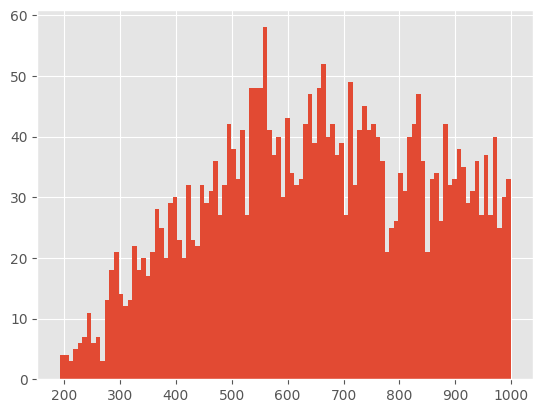

Max length: 849


In [25]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
lengths = [len(row['context'] + row['question']) for row in squad['train']]
plt.hist(lengths, bins=100)
plt.show()
target_max_length = int(np.percentile(lengths, 80))
print(f"Max length: {target_max_length}")

**Justification for prompt**

The prompts are collected from Flan 2022 Collection (Chung et al, arXiv:2210.11416).

Ref: https://arxiv.org/abs/2301.13688
Prompts are selected from this github https://github.com/google-research/FLAN/blob/main/flan/v2/flan_templates_branched.py



In [26]:
def preprocess_data(examples):
  """Adds prefix, tokenizes and sets the labels"""
  questions = examples["question"]
  contexts = examples["context"]
  titles = examples["title"]
  answers = []
  for answer in examples["answers.text"]:
    answers.append(answer[0])
  inputs = []
  for question, context in zip(questions, contexts):
    prefix = f"""Answer a question about this article:\n{context}\nQ:{question}A:"""
    input = prefix.format(context=context.strip(), question=question.strip())
    inputs.append(input)
  model_inputs = tokenizer(inputs,
                           truncation=True,
                           padding="max_length",
                           return_tensors='pt',
                           max_length=target_max_length)
  labels = tokenizer(text_target=answers, max_length=target_max_length, truncation=True)
  model_inputs["labels"] = labels["input_ids"]
  return model_inputs

tensored_data = squad.map(preprocess_data, remove_columns=squad["train"].column_names, batched=True)

Map:   0%|          | 0/3007 [00:00<?, ? examples/s]

Map:   0%|          | 0/769 [00:00<?, ? examples/s]

In [27]:
tensored_data

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3007
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 769
    })
})

In [28]:
tokenizer.decode(tensored_data["train"][0]["input_ids"], skip_special_tokens=True)

'Answer a question about this article: The Desert Land Act of 1877 was passed to allow settlement of arid lands in the west and allotted 640 acres (2.6 km2) to settlers for a fee of $.25 per acre and a promise to irrigate the land. After three years, a fee of one dollar per acre would be paid and the land would be owned by the settler. This act brought mostly cattle and sheep ranchers into Montana, many of whom grazed their herds on the Montana prairie for three years, did little to irrigate the land and then abandoned it without paying the final fees. Some farmers came with the arrival of the Great Northern and Northern Pacific Railroads throughout the 1880s and 1890s, though in relatively small numbers. Q:How much was the charge per acre at first?A:'

In [29]:
tokenizer.decode(tensored_data["train"][0]["labels"], skip_special_tokens=True)

'$.25'

In [30]:
tokenizer.decode(tensored_data["train"][20]["input_ids"], skip_special_tokens=True)

'Answer a question about this article: The games are in the form of.ipg files, which are actually.zip archives in disguise[citation needed]. When unzipped, they reveal executable files along with common audio and image files, leading to the possibility of third party games. Apple has not publicly released a software development kit (SDK) for iPod-specific development. Apps produced with the iPhone SDK are compatible only with the iOS on the iPod Touch and iPhone, which cannot run clickwheel-based games. Q:What file format is being covered up by the use of ipg files?A:'

In [31]:
tokenizer.decode(tensored_data["train"][20]["labels"], skip_special_tokens=True)

'.zip'

In [32]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_name)

## Training Arguments

In [33]:
# Global Parameters
L_RATE = 5e-5
BATCH_SIZE = 8
PER_DEVICE_EVAL_BATCH = 8
WEIGHT_DECAY = 0.01
SAVE_TOTAL_LIM = 3
NUM_EPOCHS = 3

def compute_metrics(eval_preds):
   preds, labels = eval_preds
   # decode preds and labels
   labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
   decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
   decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
   # rougeLSum expects newline after each sentence
   decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
   decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
   result = rogue_metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
   return result

# Set up training arguments
training_args = Seq2SeqTrainingArguments(
   output_dir="./results",
   evaluation_strategy="epoch",
   learning_rate=L_RATE,
   per_device_train_batch_size=BATCH_SIZE,
   per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH,
   weight_decay=WEIGHT_DECAY,
   save_total_limit=SAVE_TOTAL_LIM,
   num_train_epochs=NUM_EPOCHS,
   predict_with_generate=True,
   push_to_hub=False
)

## Training

In [34]:
trainer = Seq2SeqTrainer(
   model=model,
   args=training_args,
   train_dataset=tensored_data["train"],
   eval_dataset=tensored_data["test"],
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics
)

In [35]:
# with 5k rows in data, training time on T4 -> 10 min
# Complete dataset, 10 epochs -> 1-2 hours
trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,No log,27.311766,0.001300,0.000000,0.001300,0.001329
2,40.831600,26.882822,0.002712,0.000000,0.002768,0.002647
3,33.034800,26.571192,0.004357,0.000000,0.004476,0.004391


TrainOutput(global_step=1128, training_loss=36.38874546348626, metrics={'train_runtime': 567.0395, 'train_samples_per_second': 15.909, 'train_steps_per_second': 1.989, 'total_flos': 1390335535401984.0, 'train_loss': 36.38874546348626, 'epoch': 3.0})

## Evaluate

In [36]:
trainer.evaluate()

{'eval_loss': 26.571191787719727,
 'eval_rouge1': 0.004356564905979731,
 'eval_rouge2': 0.0,
 'eval_rougeL': 0.004476025347286725,
 'eval_rougeLsum': 0.004390880756290379,
 'eval_runtime': 30.5414,
 'eval_samples_per_second': 25.179,
 'eval_steps_per_second': 3.176,
 'epoch': 3.0}

In [37]:
last_checkpoint = "./results/checkpoint-500"
finetuned_model = T5ForConditionalGeneration.from_pretrained(last_checkpoint)
tokenizer = T5Tokenizer.from_pretrained(last_checkpoint)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [38]:
my_question = "What do you think about the benefit of Artificial Intelligence?"
inputs = "Please answer to this question: " + my_question
inputs = tokenizer(inputs, return_tensors="pt")
outputs = finetuned_model.generate(**inputs)
print(outputs[0])
answer = tokenizer.decode(outputs[0], skip_special_tokens=False)
print(answer)

tensor([0, 3, 1])
<pad> </s>


In [39]:
for i in range(3):
  random_idx = random.randint(0, len(squad["train"]))
  question = squad["train"][random_idx]["question"]
  context = squad["train"][random_idx]["context"]
  title = squad["train"][random_idx]["title"]
  baseline_answer = squad["train"][random_idx]["answers.text"]
  prompt = f"""Please answer a question about the following article about {title}\n{context}\n\nQ: {question}"""
  print(prompt)
  print("====="*10)
  print("Baseline answer:")
  print(baseline_answer)
  print("====="*10)
  sentence_encoded = tokenizer(prompt, return_tensors='pt', max_length=target_input_length, truncation=True)
  pred_answer = finetuned_model.generate(sentence_encoded['input_ids'], max_new_tokens=100)
  sentence_decoded = tokenizer.decode(pred_answer[0], skip_special_tokens=True)
  print("Generated Answer")
  print(sentence_decoded)
  print("====="*10)
  rouge_score = rogue_metric.compute(predictions=[sentence_decoded], references=[baseline_answer])
  print(rouge_score)
  print("#####"*20)

Please answer a question about the following article about To_Kill_a_Mockingbird
The novel is renowned for its warmth and humor, despite dealing with the serious issues of rape and racial inequality. The narrator's father, Atticus Finch, has served as a moral hero for many readers and as a model of integrity for lawyers. One critic explains the novel's impact by writing, "In the twentieth century, To Kill a Mockingbird is probably the most widely read book dealing with race in America, and its protagonist, Atticus Finch, the most enduring fictional image of racial heroism."

Q: Who is the protagonist of the novel?
Baseline answer:
['Atticus Finch']
Generated Answer

{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'rougeLsum': 0.0}
####################################################################################################
Please answer a question about the following article about Sino-Tibetan_relations_during_the_Ming_dynasty
When the Dzungar Mongols attempted to spread their ter

The model's performance is poor, this is expected since we have not fully tuned the model with complete data. Completely training the model using the complete SQUAD dataset will take few hours.

# Appendix

In this section we will learn different approaches to improve the model performance.

## Training only few layers

Since training all the layers of the model will take time, in this section we will freeze few layers and fine tune remaining layers.

In [40]:
# reload the model
tokenizer = AutoTokenizer.from_pretrained(model_name)
frozen_model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

In [41]:
frozen_model

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
              (wo): 

In [42]:
modules_to_freeze = [frozen_model.encoder.block[i].layer[0] for i in range(len(frozen_model.encoder.block))]
modules_to_freeze.extend([frozen_model.decoder.block[i].layer[0] for i in range(len(frozen_model.decoder.block))])
modules_to_freeze.extend([frozen_model.decoder.block[i].layer[1] for i in range(len(frozen_model.decoder.block))])

for module in modules_to_freeze:
  for param in module.parameters():
    param.requires_grad = False
total_params, trainable_params = print_parameters_summary(frozen_model)
print(f'Total params: {format_number_to_millions(total_params)}')
print(f'Trainable params: {format_number_to_millions(trainable_params)}')

Total params: 76.96M
Trainable params: 58.07M


In [43]:
for name, param in frozen_model.named_parameters():
    print(name, param.requires_grad)

shared.weight True
encoder.block.0.layer.0.SelfAttention.q.weight False
encoder.block.0.layer.0.SelfAttention.k.weight False
encoder.block.0.layer.0.SelfAttention.v.weight False
encoder.block.0.layer.0.SelfAttention.o.weight False
encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight False
encoder.block.0.layer.0.layer_norm.weight False
encoder.block.0.layer.1.DenseReluDense.wi_0.weight True
encoder.block.0.layer.1.DenseReluDense.wi_1.weight True
encoder.block.0.layer.1.DenseReluDense.wo.weight True
encoder.block.0.layer.1.layer_norm.weight True
encoder.block.1.layer.0.SelfAttention.q.weight False
encoder.block.1.layer.0.SelfAttention.k.weight False
encoder.block.1.layer.0.SelfAttention.v.weight False
encoder.block.1.layer.0.SelfAttention.o.weight False
encoder.block.1.layer.0.layer_norm.weight False
encoder.block.1.layer.1.DenseReluDense.wi_0.weight True
encoder.block.1.layer.1.DenseReluDense.wi_1.weight True
encoder.block.1.layer.1.DenseReluDense.wo.weight True
encoder

In [44]:
trainer = Seq2SeqTrainer(
   model=frozen_model,
   args=training_args,
   train_dataset=tensored_data["train"],
   eval_dataset=tensored_data["test"],
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics
)

In [45]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,No log,0.321248,0.844958,0.527299,0.844480,0.844316
2,0.494200,0.318914,0.847707,0.529223,0.847331,0.846818
3,0.454200,0.319112,0.848304,0.529452,0.847847,0.847499


TrainOutput(global_step=1128, training_loss=0.47526818471597443, metrics={'train_runtime': 688.9558, 'train_samples_per_second': 13.094, 'train_steps_per_second': 1.637, 'total_flos': 2780671070803968.0, 'train_loss': 0.47526818471597443, 'epoch': 3.0})

Notice the model's performance is improved.

In [46]:
for i in range(3):
  random_idx = random.randint(0, len(squad["train"]))
  question = squad["train"][random_idx]["question"]
  context = squad["train"][random_idx]["context"]
  title = squad["train"][random_idx]["title"]
  baseline_answer = squad["train"][random_idx]["answers.text"]
  prompt = f"""Please answer a question about the following article about {title}\n{context}\n\nQ: {question}"""
  print(prompt)
  print("====="*10)
  print("Baseline answer:")
  print(baseline_answer)
  print("====="*10)
  sentence_encoded = tokenizer(prompt, return_tensors='pt', max_length=256, truncation=True)
  frozen_model = frozen_model.to("cuda")
  pred_answer = frozen_model.generate(input_ids=sentence_encoded['input_ids'].cuda())
  sentence_decoded = tokenizer.decode(pred_answer[0], skip_special_tokens=True)
  print("Generated Answer")
  print(sentence_decoded)
  print("====="*10)
  rouge_score = rogue_metric.compute(predictions=[sentence_decoded], references=[baseline_answer])
  print(rouge_score)
  print("#####"*20)

Please answer a question about the following article about To_Kill_a_Mockingbird
The novel is renowned for its warmth and humor, despite dealing with the serious issues of rape and racial inequality. The narrator's father, Atticus Finch, has served as a moral hero for many readers and as a model of integrity for lawyers. One critic explains the novel's impact by writing, "In the twentieth century, To Kill a Mockingbird is probably the most widely read book dealing with race in America, and its protagonist, Atticus Finch, the most enduring fictional image of racial heroism."

Q: Who is the protagonist of the novel?
Baseline answer:
['Atticus Finch']
Generated Answer
Atticus Finch
{'rouge1': 1.0, 'rouge2': 1.0, 'rougeL': 1.0, 'rougeLsum': 1.0}
####################################################################################################
Please answer a question about the following article about Sino-Tibetan_relations_during_the_Ming_dynasty
When the Dzungar Mongols attempted to spr

## Apply PEFT

Parameter efficient fine tuning is an approach towards fine tuning large language models that fine tunes the model without altering all the model weights. You can learn more about it from my block post [here](https://www.linkedin.com/pulse/finetuning-large-language-models-using-novel-peft-srikanth-machiraju-owe2c%3FtrackingId=AVwu8o6uR%252F6J3n0BB6U7IA%253D%253D/?trackingId=AVwu8o6uR%2F6J3n0BB6U7IA%3D%3D)

In [47]:
%%bash
pip install -q peft

In [48]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)
print(model)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
              (wo): 

In [49]:
from peft import PeftModel, PeftConfig, LoraConfig, TaskType
from peft import get_peft_config, get_peft_model, get_peft_model_state_dict, LoraConfig, TaskType

lora_config = LoraConfig(
    r=16, #Rank
    lora_alpha=32,
    target_modules=["lm_head"], # we can use layer names from above to target more modules, here I'm only training linear layer, we can also do q, v
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM # FLAN-T5
)

peft_model = get_peft_model(model, lora_config)
peft_model = peft_model.to("cuda")
tokenizer = AutoTokenizer.from_pretrained(model_name)
peft_model.print_trainable_parameters()

training_args = Seq2SeqTrainingArguments(
   output_dir="./peft_results",
   learning_rate=1e-3,
   num_train_epochs=1,
   predict_with_generate=True
)

trainer = Seq2SeqTrainer(
   model=peft_model,
   args=training_args,
   train_dataset=tensored_data["train"],
   eval_dataset=tensored_data["test"],
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics
)

trainable params: 522,240 || all params: 77,483,392 || trainable%: 0.6740025010779084


In [50]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=376, training_loss=0.5689411569148937, metrics={'train_runtime': 90.7444, 'train_samples_per_second': 33.137, 'train_steps_per_second': 4.144, 'total_flos': 934889850648576.0, 'train_loss': 0.5689411569148937, 'epoch': 1.0})

In [51]:
for i in range(3):
  random_idx = random.randint(0, len(squad["train"]))
  question = squad["train"][random_idx]["question"]
  context = squad["train"][random_idx]["context"]
  title = squad["train"][random_idx]["title"]
  baseline_answer = squad["train"][random_idx]["answers.text"]
  prompt = f"""Please answer a question about the following article about {title}\n{context}\n\nQ: {question}"""
  print(prompt)
  print("====="*10)
  print("Baseline answer:")
  print(baseline_answer)
  print("====="*10)
  sentence_encoded = tokenizer(prompt, return_tensors='pt', max_length=256, truncation=True)
  peft_model = peft_model.to("cuda")
  pred_answer = peft_model.generate(input_ids=sentence_encoded['input_ids'].cuda())
  sentence_decoded = tokenizer.decode(pred_answer[0], skip_special_tokens=True)
  print("Generated Answer")
  print(sentence_decoded)
  print("====="*10)
  rouge_score = rogue_metric.compute(predictions=[sentence_decoded], references=[baseline_answer])
  print(rouge_score)
  print("#####"*20)

Please answer a question about the following article about To_Kill_a_Mockingbird
The novel is renowned for its warmth and humor, despite dealing with the serious issues of rape and racial inequality. The narrator's father, Atticus Finch, has served as a moral hero for many readers and as a model of integrity for lawyers. One critic explains the novel's impact by writing, "In the twentieth century, To Kill a Mockingbird is probably the most widely read book dealing with race in America, and its protagonist, Atticus Finch, the most enduring fictional image of racial heroism."

Q: Who is the protagonist of the novel?
Baseline answer:
['Atticus Finch']
Generated Answer
Atticus Finch
{'rouge1': 1.0, 'rouge2': 1.0, 'rougeL': 1.0, 'rougeLsum': 1.0}
####################################################################################################
Please answer a question about the following article about Sino-Tibetan_relations_during_the_Ming_dynasty
When the Dzungar Mongols attempted to spr

The model's performance is almost same as freezing few layers. However, the key difference to know is that in LORA the all the parameters are frozen and only the LORA weights are fine tuned.

## Fine tuning using Human feedback

https://github.com/sriksmachi/sriksml/blob/main/language-models/fine_tuning_llms_rlhf.ipynb